# Reverse SuCOS scoring method

1. Break designed compound into bits at rotable bonds
2. SuCOS score these individual bits to all the fragments - a high sucCOS score would indicate that the shape/chem feature of the bit is best captured by that fragment
3. Capture best matching fragment IDs and bits
4. Score using Score_1, Score_2 and Score_3 as described in the README
5. All fragment matches captured in sdf file
6. Top fragment matches with reverse SuCOS scores of > 0.50 also captured in sdf file

In [42]:
from rdkit.Chem.Lipinski import RotatableBondSmarts
from rdkit.Chem import BRICS
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.FeatMaps import FeatMaps
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit import RDConfig
import os
import numpy as np
import pandas as pd
from datetime import datetime

date = datetime.today().strftime('%Y-%m-%d')

def getBits(mol):
    '''

    Parameters
    ----------
    mol : rdkit mol object to be broken up into fragments by breaking 
    rotable bonds

    Returns
    -------
    mols : A list of rdkit mol objects

    '''
    # find the rotatable bonds
    bonds = mol.GetSubstructMatches(RotatableBondSmarts)
    
    bonds = [((x,y),(0,0)) for x,y in bonds]
    p = BRICS.BreakBRICSBonds(mol,bonds=bonds)
 
    mols = [mol for mol in Chem.GetMolFrags(p,asMols=True)]
    
    return mols

# Function to build feature maps and score two mol objects
fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

def getFeatureMapScore(small_m, large_m, score_mode=FeatMaps.FeatMapScoreMode.All):
    try: 
        featLists = []
        for m in [small_m, large_m]:
            rawFeats = fdef.GetFeaturesForMol(m)
            # filter that list down to only include the ones we're intereted in
            featLists.append([f for f in rawFeats if f.GetFamily() in keep])
        fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
        fms[0].scoreMode = score_mode
        fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
        return fm_score
    except ZeroDivisionError:
        return 0

# We need to start by building a FeatureFactory object which defines 
# the set of pharmacophore features being used. 
# We'll use this to find features on the molecules.
fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 
                                                'BaseFeatures.fdef'))


# Set default paramters for selecting points in feature map
fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

# List of feature families that we want to use
keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')


def getSDFprops(compound_mol):
    # Need to change for diff sdf files!!!
    
    # Make smiles = original SMILES 
    compound_mol.SetProp('original SMILES', Chem.MolToSmiles(compound_mol))
    
    # Assign ref pdb
    compound_mol.SetProp('ref_pdb', 'Fragmenstein.pdb')
    
    # Get all the sdf properties
    all_properties = list(compound_mol.GetPropsAsDict().keys())

    # Properties to keep 
    keep_properties = ['ref_pdb', 'ref_mols', 'original SMILES'] 

    # Properties to delete
    del_properties = [prop for prop in all_properties if prop not in keep_properties]

    for prop in del_properties:
            compound_mol.ClearProp(prop)

    return compound_mol


def getBlankMol(blank_mol, COS_threshold):
    
    # Add compulsory props
    blank_mol.SetProp('_Name', 'ver_1.2')
    blank_mol.SetProp('ref_mols', 'Fragments that bits overlap with above a score threshold of {}.'.format(COS_threshold))
    blank_mol.SetProp('ref_url', 'https://github.com/Waztom/xchem-xCOS')
    blank_mol.SetProp('submitter_name', 'WT')
    blank_mol.SetProp('submitter_email', 'warren.thompson@diamond.ac.uk')
    blank_mol.SetProp('submitter_institution', 'Diamond Light Source')
    blank_mol.SetProp('generation_date', date)
    blank_mol.SetProp('method', 'xCOS')

    # Add scoring descriptors
    blank_mol.SetProp('N_hits', 'The number of fragments that bits overlap with above a score threshold of {}.'.format(COS_threshold))
    blank_mol.SetProp('Score_1', 'The score is scaled by the number of bit atoms')    
    
    return blank_mol


In [43]:
# Read in fragment mols
frag_mol_folder = 'in_data/fragment_mols'
path  = frag_mol_folder + '/'
frag_mol_list = [Chem.MolFromMolFile((path + mol_file), sanitize=True) for mol_file in os.listdir(frag_mol_folder)]

In [44]:
# Use if we want to load docking sdf file
compound_mols = frag_mol_list

In [45]:
def getReverseScores(compound_mols, COS_threshold, filename):
    
    # Get writer set up for writing final mols to file
    w = Chem.SDWriter(filename)
    
    # Sort out blank mole
    blank_mol = compound_mols[0]
    
    # Keep sdf props we want
    blank_mol = getSDFprops(blank_mol)

    # Assign required props for ver 1.2 spec
    blank_mol = getBlankMol(blank_mol, COS_threshold)

    # Write to file
    w.write(blank_mol)
    
    # Score eveything besides for first mol
    for i in range(len(compound_mols)):
        
        index = i + 1
        
        if index < len(compound_mols):
            
            # Get compound mol
            compound_mol = compound_mols[index]
            
            # Get no compound mol atoms for scaling score
            no_compound_atoms = compound_mol.GetNumAtoms()
            
            # Get the bits
            compound_bits = getBits(compound_mol)
                       
            all_scores = []

            for bit in compound_bits:
            
                # Get number of bit atoms
                no_bit_atoms = bit.GetNumAtoms()
                
                scores = []
                
                for frag_mol in frag_mol_list:
                    
                        # Get some info and append to list
                        frag_name = frag_mol.GetProp('_Name').strip('Mpro-')
                        
                        # Check if MCS yield > 0 atoms
                        mcs_match = rdFMCS.FindMCS([bit,frag_mol],ringMatchesRingOnly=True,
                                                   matchValences=True)
                        
                        # Get number of atoms in MCS match found
                        no_mcs_atoms = Chem.MolFromSmarts(mcs_match.smartsString).GetNumAtoms()
                            
                        if no_mcs_atoms == 0:
                            
                            scores.append((frag_name, 0, no_bit_atoms))
                        
                        if no_mcs_atoms > 0:
                            
                            # NB reverse SuCOS scoring
                            fm_score = getFeatureMapScore(bit, frag_mol)
                            fm_score = np.clip(fm_score, 0, 1)
                            
                            # Change van der Waals radius scale for stricter overlay
                            protrude_dist = rdShapeHelpers.ShapeProtrudeDist(bit, frag_mol,
                                                                             allowReordering=False,
                                                                             vdwScale=0.2)
                            protrude_dist = np.clip(protrude_dist, 0, 1)

                            # Use SuCOS score
                            reverse_SuCOS_score = 0.5*fm_score + 0.5*(1 - protrude_dist)
                                      
                            scores.append((frag_name, reverse_SuCOS_score, no_bit_atoms))

                all_scores.append(scores)

                list_dfs = [] 
                
                for score in all_scores:
                    
                    df = pd.DataFrame(data=score, columns = ['Fragment','Score','No_bit_atoms'])
                    
                    # Get maximum scoring fragment for bit match
                    df = df[df['Score'] == df['Score'].max()]
                    list_dfs.append(df)

                final_df = pd.concat(list_dfs)

                # Get total bit score and some denominator terms
                bits_score = (final_df.No_bit_atoms * final_df.Score).sum()
                total_atoms = final_df.No_bit_atoms.sum()
                
                # Score 1: the score is scaled by the number of bit atoms
                score_1 = bits_score

                # Let's only get frags above a threshold 
                final_df = final_df[final_df.Score > COS_threshold]

                # Let's sort the df by increasing score
                final_df = final_df.sort_values(by=['Score'], ascending=False)

                # Get the unique fragments above threshold
                all_frags = pd.unique(final_df.Fragment)

            # Set sdf props - see function for props to keep and drop            
            compound_mol = getSDFprops(compound_mol)

            # Add props we want                                   
            compound_mol.SetProp('ref_mols',','.join(all_frags))
            compound_mol.SetProp('N_hits', str(len(all_frags)))
            compound_mol.SetProp('Score_1', "{:.4f}".format(score_1))

            # Write to file
            w.write(compound_mol)

In [46]:
# Let's do all of the compounds
getReverseScores(compound_mols=compound_mols,
                 COS_threshold=0.45, 
                 filename='out_data/xCOS_frag_test_{}.sdf'.format(date))

In [47]:
# Let's see about dealing with wrong features mapping 
frag_mol = Chem.SDMolSupplier('out_data/Mpro-x1382.sdf')

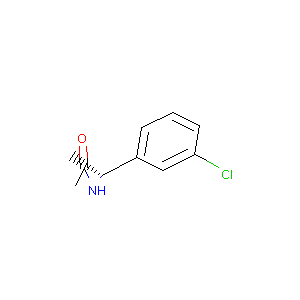

In [49]:
# # Let's have a look at the first mol as an example
Chem.Draw.MolToImage(frag_mol[0])

In [50]:
# Let's break the first mol into bits 
compound_bits = getBits(frag_mol[0])

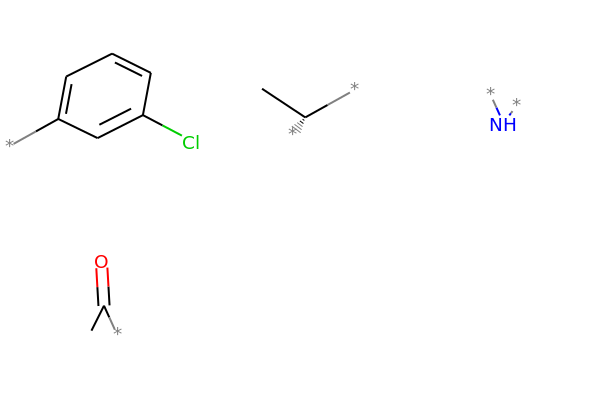

In [51]:
# What are the bits?
Draw.MolsToGridImage(compound_bits, molsPerRow=3)

In [53]:
# Load frag that has shitty overlay 
test_mol = Chem.MolFromMolFile('in_data/fragment_mols/Mpro-x0708.mol')

In [59]:
bit_test = compound_bits[1]

# Check if MCS yield > 0 atoms
mcs_match = rdFMCS.FindMCS([bit_test,test_mol],ringMatchesRingOnly=True,
                           matchValences=True)

# Get number of atoms in MCS match found
no_mcs_atoms = Chem.MolFromSmarts(mcs_match.smartsString).GetNumAtoms()

True


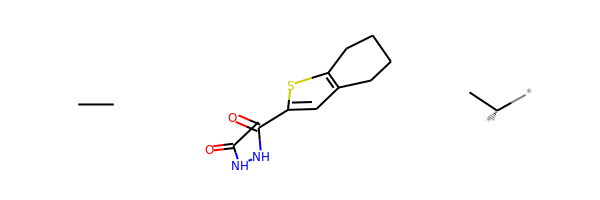

In [60]:
# can we use this MCS info to test if bit group anywhere close to MCS/s in frag? 
## Need top test with frag with 2 x CO!!!!
mcs_mol = Chem.MolFromSmarts(mcs_match.smartsString)

# Get position where MCS mol is in frag
print(test_mol.HasSubstructMatch(mcs_mol))

Draw.MolsToGridImage([mcs_mol,test_mol,bit_test])

In [61]:
# Ok got match - what about substructures positions
match_ids = test_mol.GetSubstructMatches(mcs_mol)
print(match_ids)
# make a flat list of teh macthing atom ids
match_ids = [item for sublist in match_ids for item in sublist]
match_ids

((1, 3), (6, 7), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14))


[1, 3, 6, 7, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14]

In [88]:
# Try sanitize bits
[Chem.SanitizeMol(x) for x in compound_bits]

[rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE,
 rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE]

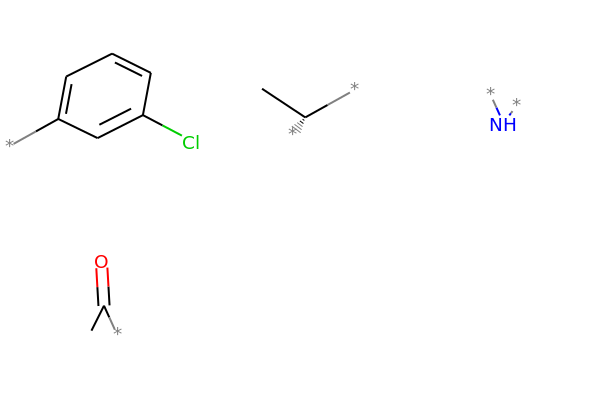

In [89]:
# What are the bits?
Draw.MolsToGridImage(compound_bits, molsPerRow=3)

In [90]:
def MolWithoutIsotopesToSmiles(mol):
  atom_data = [(atom, atom.GetIsotope()) for atom in mol.GetAtoms()]
  for atom, isotope in atom_data:
      if isotope:
          atom.SetIsotope(0)
  smiles = Chem.MolToSmiles(mol)
  for atom, isotope in atom_data:
      if isotope:
          atom.SetIsotope(isotope)
  return smiles

In [97]:
for atom in compound_bits[0].GetAtoms():
    print(atom.GetAtomicNum())


17
6
6
6
6
6
6
0


In [96]:
atoms